In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style='darkgrid')

# Data Inspection

In [3]:
vehicles_raw = pd.read_csv('data/vehicles.csv')

In [4]:
vehicles_raw.head(2)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar


In [5]:
vehicles_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

## Inspect: Nulls

In [7]:
vehicles_raw.isnull().sum().transform(lambda x: (1 - (x / vehicles_raw.shape[0])) * 100).round(2)

id              100.00
region          100.00
price           100.00
year             99.72
manufacturer     95.87
model            98.76
condition        59.21
cylinders        58.38
fuel             99.29
odometer         98.97
title_status     98.07
transmission     99.40
VIN              62.27
drive            69.41
size             28.23
type             78.25
paint_color      69.50
state           100.00
dtype: float64

In [8]:
vehicles_raw.describe().style.format('{:,.2f}')

,id,price,year,odometer
count,"426,880.00","426,880.00","425,675.00","422,480.00"
mean,"7,311,486,634.22","75,199.03","2,011.24","98,043.33"
std,"4,473,170.41","12,182,282.17",9.45,"213,881.50"
min,"7,207,408,119.00",0.00,"1,900.00",0.00
25%,"7,308,143,339.25","5,900.00","2,008.00","37,704.00"
50%,"7,312,620,821.00","13,950.00","2,013.00","85,548.00"
75%,"7,315,253,543.50","26,485.75","2,017.00","133,542.50"
max,"7,317,101,084.00","3,736,928,711.00","2,022.00","10,000,000.00"


## Inspect: Price

Since price will be our target parameter for models, let's check it first

### Price = 0 case

In [11]:
veh_zero_price = vehicles_raw.query('price == 0')
veh_zero_price.price.value_counts()

price
0    32895
Name: count, dtype: int64

In [12]:
veh_zero_price.describe().style.format('{:,.2f}')

,id,price,year,odometer
count,"32,895.00","32,895.00","32,863.00","30,785.00"
mean,"7,311,551,883.13",0.00,"2,013.97","89,312.68"
std,"4,484,307.42",0.00,6.36,"297,007.17"
min,"7,209,027,818.00",0.00,"1,903.00",0.00
25%,"7,308,226,344.00",0.00,"2,012.00","34,908.00"
50%,"7,312,520,029.00",0.00,"2,015.00","72,000.00"
75%,"7,315,315,941.00",0.00,"2,017.00","110,000.00"
max,"7,317,080,869.00",0.00,"2,022.00","10,000,000.00"


In [13]:
veh_zero_price_pct = (veh_zero_price.shape[0] / vehicles_raw.shape[0]) * 100
veh_zero_price_pct

7.7059126686656665

There are 32,895 cars with a zero price, 7.71% of the total - reasonable candidates for exclusion!

### Price Distribution

Let's look at the price distribution of cars with non-zero prices

In [17]:
veh_priced = vehicles_raw.query('price > 0')

<Axes: >

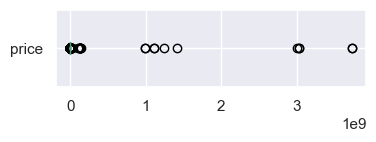

In [18]:
veh_priced.price.plot.box(vert=False, figsize=(4,1))

In [19]:
veh_priced.describe().T.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
id,"393,985.00","7,311,481,186.40","4,472,201.94","7,207,408,119.00","7,308,131,294.00","7,312,625,769.00","7,315,249,600.00","7,317,101,084.00"
price,"393,985.00","81,477.63","12,680,636.89",1.00,"7,000.00","15,000.00","27,590.00","3,736,928,711.00"
year,"392,812.00","2,011.01",9.63,"1,900.00","2,008.00","2,013.00","2,017.00","2,022.00"
odometer,"391,695.00","98,729.51","205,915.79",0.00,"38,000.00","87,000.00","135,334.00","10,000,000.00"


The price min/max is all over the place and the quartile distribution is strange - let's dig deeper into this when we look at outliers later

Let's look at cars under 100K

<Axes: ylabel='Count'>

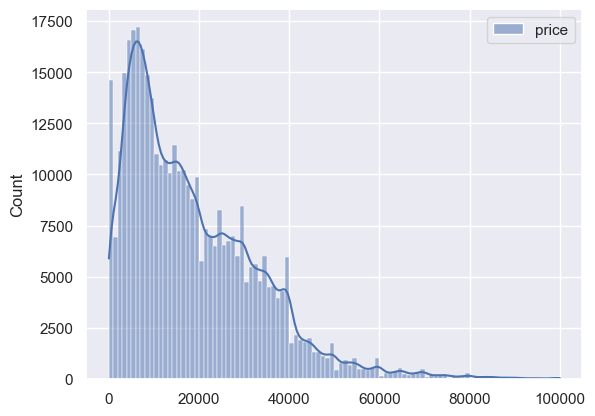

In [21]:
price_cap = 100000
sns.histplot(vehicles_raw.query('price > 0 and price <= @price_cap')[['price']], bins=100, kde=True)

Massive skew - let's play with outliers now

### Price Outliers

#### Outliers Method 1: Simple quartile analysis

In [25]:
# Calculate IQR
Q1 = vehicles_raw['price'].quantile(0.25)
Q3 = vehicles_raw['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
vehicles_iqr = vehicles_raw[(vehicles_raw['price'] >= lower_bound) & (vehicles_raw['price'] <= upper_bound)]

# Plot the distribution again
# plt.figure(figsize=(10, 6))
# sns.histplot(vehicles_iqr['price'], bins=30, kde=True)
# plt.title('Price Distribution After IQR [#Orig: {:,}; Removed: {:,}]'.
#           format(vehicles_raw.shape[0], vehicles_raw.shape[0] - vehicles_iqr.shape[0]))
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.show()

#### Outliers Method 2: Modified z-score

Source: https://medium.com/towards-data-science/3-simple-statistical-methods-for-outlier-detection-db762e86cd9d

In [27]:
# Calculate Mod-Z score

import time

# Apply the above function to the entire column to get a modified
# z score for every data point.
temp = vehicles_raw#[0:100000]
modz = (np.abs(temp['price'] - temp['price'].median())).median()
med = temp['price'].median()
const = 0.6745
print('ModZ: {}, med: {}, const: {}'.format(modz, med, const))

start_time = time.time()
temp['mod_zscore'] = temp['price'].transform(lambda x: (const * (x - med) / modz))
end_time = time.time()
print('Time: {}'.format(end_time - start_time))

vehicles_modZ = temp[(temp['mod_zscore'] >= -3.5) & (temp['mod_zscore'] <= 3.5)]

# vehicles_modZ

ModZ: 9450.0, med: 13950.0, const: 0.6745
Time: 0.18918991088867188


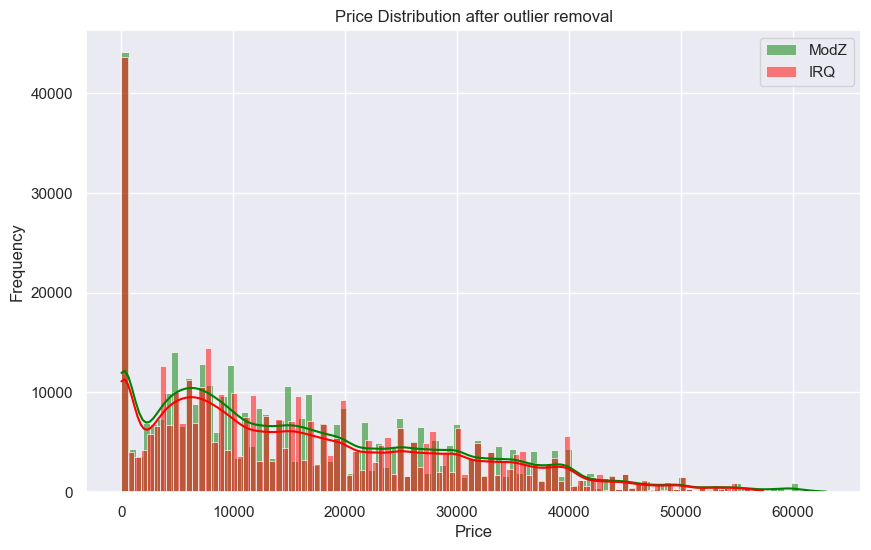

In [28]:
# Plot the distribution again
plt.figure(figsize=(10, 6))
sns.histplot(vehicles_modZ['price'], bins=100, kde=True, color='green', alpha=0.5, label='ModZ')
sns.histplot(vehicles_iqr['price'], bins=100, kde=True, color='red', alpha=0.5, label='IRQ')

plt.title('Price Distribution after outlier removal')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [29]:
print('vehicles_raw: shape: {}, min: {:,.2f}, max: {:,.2f}'.
      format(vehicles_raw.shape, vehicles_raw.price.min(), vehicles_raw.price.max()))
print('vehicles_iqr: shape: {}, min: {:,.2f}, max: {:,.2f}, Removed: {:,.0f}'.
      format(vehicles_iqr.shape, vehicles_iqr.price.min(), vehicles_iqr.price.max(), vehicles_raw.shape[0] - vehicles_iqr.shape[0]))
print('vehicles_modZ: shape: {}, min: {:,.2f}, max: {:,.2f}, Removed: {:,.0f}'.
      format(vehicles_modZ.shape, vehicles_modZ.price.min(), vehicles_modZ.price.max(), vehicles_raw.shape[0] - vehicles_modZ.shape[0]))

vehicles_raw: shape: (426880, 19), min: 0.00, max: 3,736,928,711.00
vehicles_iqr: shape: (418703, 18), min: 0.00, max: 57,341.00, Removed: 8,177
vehicles_modZ: shape: (421090, 19), min: 0.00, max: 62,981.00, Removed: 5,790


Based on the above distribution ModZ did preserved more data samples, i.e. removed only 5,790 instead of 8,177 priced vehicles, so let's analyze this further.

In [31]:
# Which set of vehicles are we looking at ...
# vehicles_sel = vehicles_raw
vehicles_sel = vehicles_modZ

In [32]:
vehicles_sel.describe().T.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
id,"421,090.00","7,311,485,749.33","4,473,251.79","7,207,408,119.00","7,308,145,995.25","7,312,617,063.00","7,315,252,755.50","7,317,101,084.00"
price,"421,090.00","16,588.75","13,510.01",0.00,"5,800.00","13,500.00","25,988.00","62,981.00"
year,"420,029.00","2,011.19",9.38,"1,900.00","2,008.00","2,013.00","2,017.00","2,022.00"
odometer,"416,750.00","98,859.49","214,470.24",0.00,"38,922.00","86,830.00","134,231.00","10,000,000.00"
mod_zscore,"421,090.00",0.19,0.96,-1.00,-0.58,-0.03,0.86,3.50


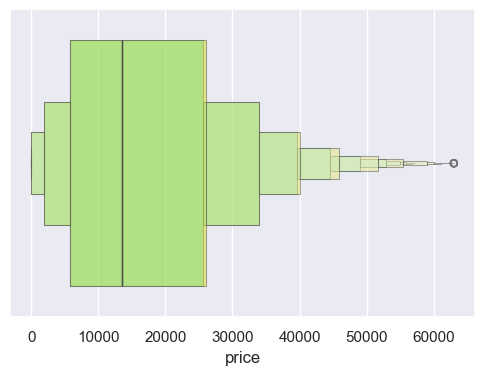

In [33]:
plt.figure(figsize=(6,4))
sns.boxenplot(data=vehicles_iqr, x='price', alpha=0.5, color='cyan')
sns.boxenplot(data=vehicles_modZ, x='price', alpha=0.5, color='yellow')
plt.show()

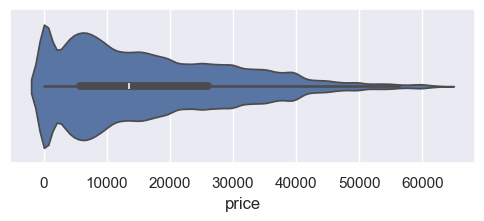

In [34]:
plt.figure(figsize=(6,2))
sns.violinplot(data=vehicles_sel, x='price')
plt.show()

### Price segmentation analysis

Looking at the above violin plot, let's look at price-based segments, **there seems to be at least a low- and mid-price band with a long tail that can be high-priced autos**

#### Market Research Resources 

1. [Auto Remarketing, July 2023: Mid-Year Market Report: Dissecting used-car pricing, segment trends, CPO sales & more](http://digital.autoremarketing.com/publication/frame.php?i=794065&p=&pn=&ver=html5&view=articleBrowser&article_id=4594802)

    * "Avearge used vehicle transaction price in the first quaretr actually dipped by 6.4% year-over-year to \\$28,381, compared to \\$30,329 in Q1 2022"

<Axes: xlabel='price', ylabel='Count'>

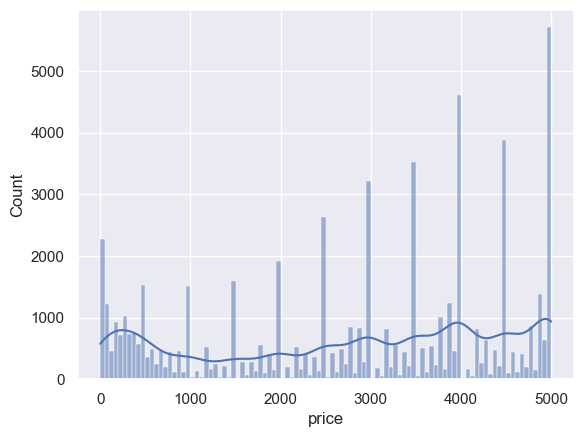

In [36]:
low_price_max = 5000
veh_low_priced = vehicles_sel.query('price > 0 and price <= @low_price_max')
sns.histplot(veh_low_priced.price, bins=100, kde=True)

In [37]:
veh_low_price_upto_1000 = vehicles_sel.query('price > 0 and price <= 1000')
veh_low_price_upto_2000 = vehicles_sel.query('price > 1000 and price <= 2000')
veh_low_price_upto_3000 = vehicles_sel.query('price > 2000 and price <= 3000')
veh_low_price_upto_4000 = vehicles_sel.query('price > 3000 and price <= 4000')
veh_low_price_upto_5000 = vehicles_sel.query('price > 4000 and price <= 5000')

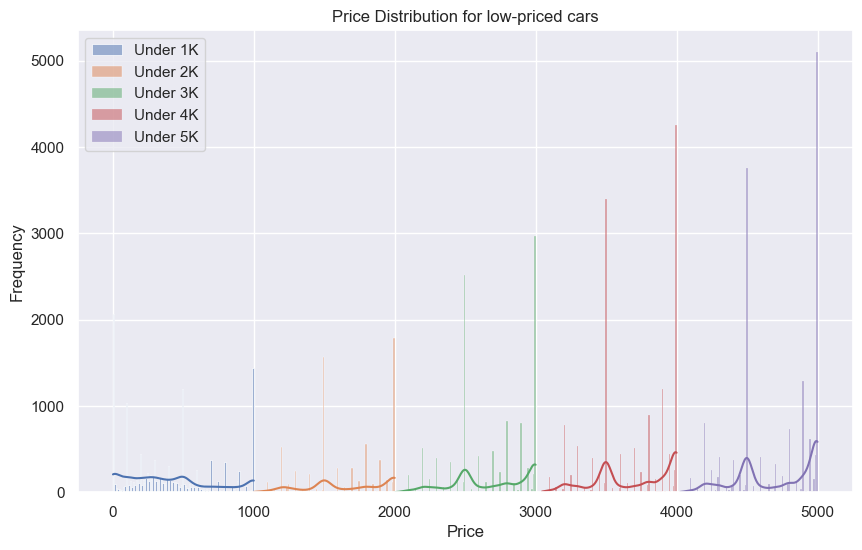

In [38]:
# Plot the distribution again
plt.figure(figsize=(10, 6))
sns.histplot(veh_low_price_upto_1000.price, bins=100, kde=True, label='Under 1K', multiple='dodge')
sns.histplot(veh_low_price_upto_2000.price, bins=100, kde=True, label='Under 2K', multiple='dodge')
sns.histplot(veh_low_price_upto_3000.price, bins=100, kde=True, label='Under 3K', multiple='dodge')
sns.histplot(veh_low_price_upto_4000.price, bins=100, kde=True, label='Under 4K', multiple='dodge')
sns.histplot(veh_low_price_upto_5000.price, bins=100, kde=True, label='Under 5K', multiple='dodge')

plt.title('Price Distribution for low-priced cars')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Pricing Findings

* There are 32,895 cars with a zero price, 7.71% of the total (426,880) - these are candidates for exclusion pending further analysis
* The price distribution shows an extreme right-skew with a long-tail with a few outliers beyond \\$100K price point
* Analyzed outliers using two separate methods (quantile analysis and Modified z-score)
    * ModZ performed better, i.e. preserved more data samples - removing only 5,790 instead of 8,177 priced vehicles
* Looking at the distribution of priced cars:
    * There seems to be at least a low- and mid-price band with a long tail that can be high-priced autos**
    * Market research on used-car prices showed an average Q12023 price of \\$28,381

**Candidate Dataset**: Based on the above findings, these are three potential price-based segments of cars with prices:

* Low-priced cars: Under \\$5K
* Mid-priced cars: \\$5K - \\$50K
* High-priced cars: ABove \\$50K

![](images/candidate-price-segments.png)


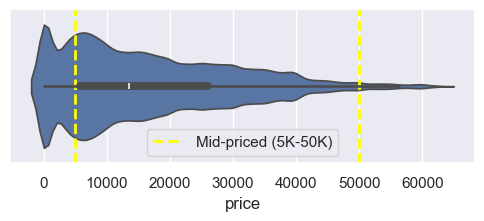

In [40]:
plt.figure(figsize=(6,2))
plt.axvline(x=5000, color='yellow', linestyle='--', linewidth=2, label='Mid-priced (5K-50K)')
plt.axvline(x=50000, color='yellow', linestyle='--', linewidth=2)
sns.violinplot(data=vehicles_sel, x='price')
plt.show()

In [41]:
# Final candidate: Priced cars (price > 0) with outliers removed
veh_priced_no_outliers = vehicles_sel.query('price > 0')

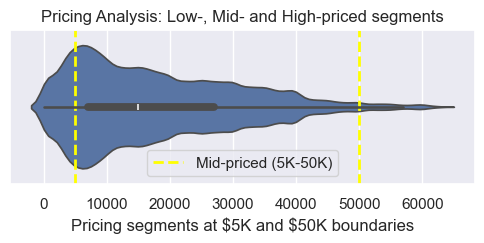

In [42]:
plt.figure(figsize=(6,2))
plt.axvline(x=5000, color='yellow', linestyle='--', linewidth=2, label='Mid-priced (5K-50K)')
plt.axvline(x=50000, color='yellow', linestyle='--', linewidth=2)
sns.violinplot(data=veh_priced_no_outliers, x='price')

plt.title('Pricing Analysis: Low-, Mid- and High-priced segments')
plt.xlabel('Pricing segments at \\$5K and \\$50K boundaries')
plt.savefig('images/candidate-price-segments.png')
plt.show()

### Multi-variate price analysis

In [116]:
veh_sample_25K = veh_priced_no_outliers.sample(n=25000, random_state=42)
veh_sample_50K = veh_priced_no_outliers.sample(n=50000, random_state=42)
veh_sample_25K.head(2)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,mod_zscore
396833,7310432605,richmond,25500,2016.0,lincoln,mkx,like new,6 cylinders,gas,27000.0,lien,automatic,NaN,4wd,mid-size,SUV,black,va,0.824389
360798,7311822521,nashville,12995,2015.0,nissan,rogue,NaN,NaN,gas,122806.0,clean,automatic,5N1AT2MT0FC830220,NaN,NaN,NaN,white,tn,-0.068164


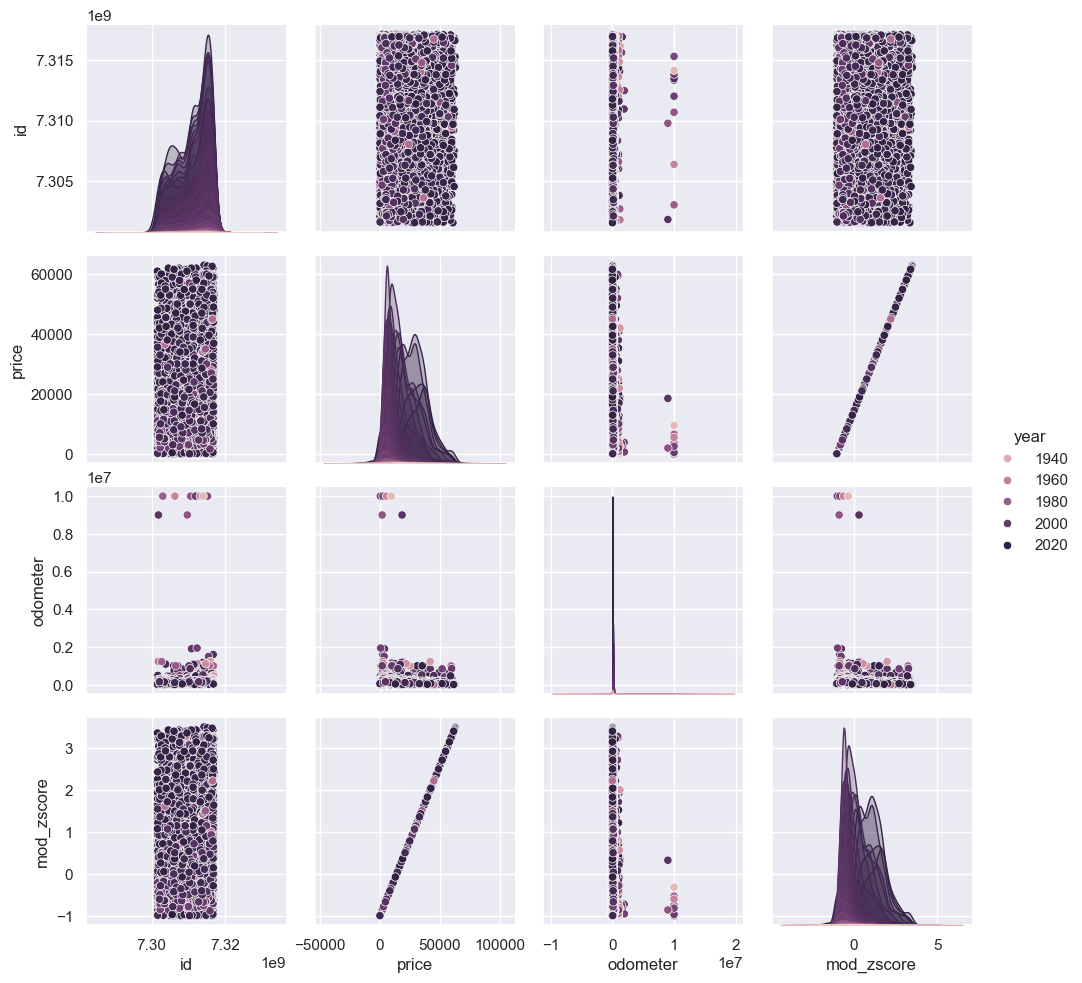

In [118]:
sns.pairplot(veh_sample_25K, hue='year')

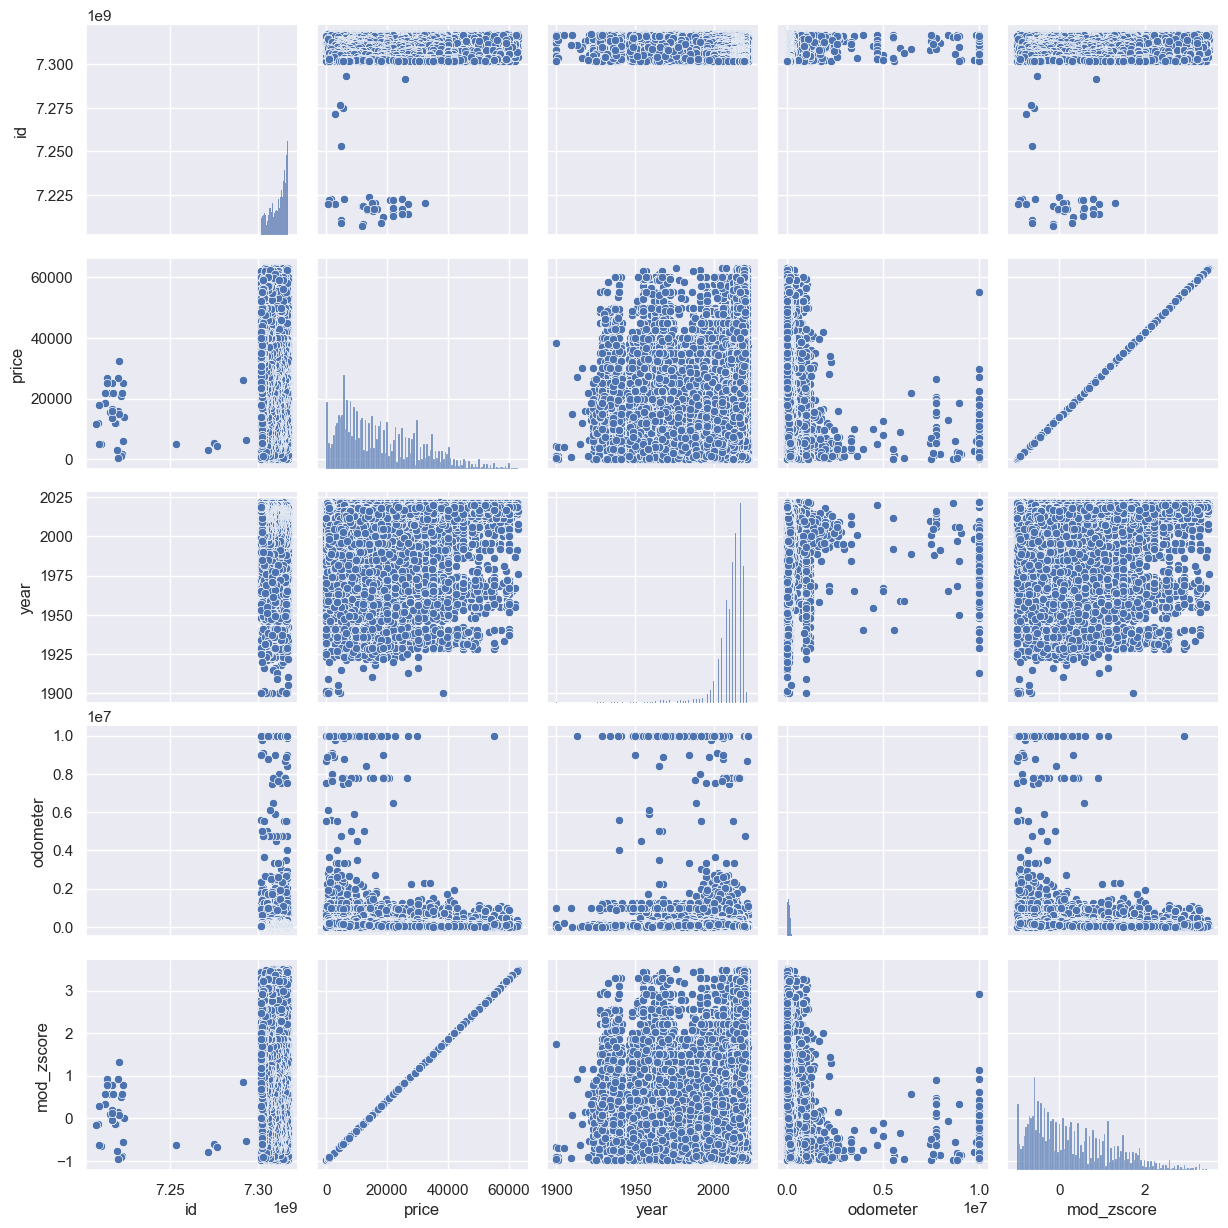

In [97]:
sns.pairplot(veh_priced_no_outliers)

<Axes: xlabel='year'>

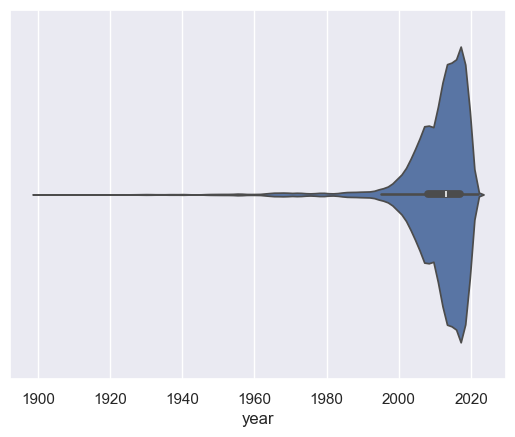

In [44]:
sns.violinplot(data=veh_priced_no_outliers, x='year')

In [45]:
# sns.displot(data=veh_zero_price, x='year', y='odometer', kind='kde', hue='price')

# Inspect: Condition

In [47]:
vehicles_raw.condition.value_counts()

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

## Inspect: VIN

In [49]:
vehicles_raw.VIN.isnull().sum()

161042

In [50]:
vehicles_raw.query('VIN == "NaN"')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,mod_zscore


In [51]:
vehicles_raw.duplicated('VIN').sum()

308633